In [50]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
import tensorflow.keras as keras

# Data wrangling

In [51]:
pd.set_option('display.max_columns', None)

In [52]:
df = pd.read_csv('Wildfire.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'fire_name','disc_date_final','cont_date_final','cont_clean_date','putout_time'])
df['disc_clean_date'] = pd.to_datetime(df['disc_clean_date'], format='%m/%d/%Y')
df.columns

Index(['fire_size', 'fire_size_class', 'stat_cause_descr', 'latitude',
       'longitude', 'state', 'disc_clean_date', 'discovery_month',
       'disc_date_pre', 'disc_pre_year', 'disc_pre_month', 'wstation_usaf',
       'dstation_m', 'wstation_wban', 'wstation_byear', 'wstation_eyear',
       'Vegetation', 'fire_mag', 'weather_file', 'Temp_pre_30', 'Temp_pre_15',
       'Temp_pre_7', 'Temp_cont', 'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7',
       'Wind_cont', 'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', 'Hum_cont',
       'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7', 'Prec_cont', 'remoteness'],
      dtype='object')

In [53]:
#one hot encoding vegetation
df['Vegetation'] = df['Vegetation'].astype('category')
df['Cause'] = df['stat_cause_descr'].astype('category')

df = pd.get_dummies(df,prefix=['Vegetation'], columns = ['Vegetation'], drop_first=True)
df = pd.get_dummies(df,prefix=['Cause'], columns = ['stat_cause_descr'], drop_first=True)

df.head()

,fire_size,fire_size_class,latitude,longitude,state,disc_clean_date,discovery_month,disc_date_pre,disc_pre_year,disc_pre_month,wstation_usaf,dstation_m,wstation_wban,wstation_byear,wstation_eyear,fire_mag,weather_file,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,Wind_pre_7,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness,Cause,Vegetation_4,Vegetation_9,Vegetation_12,Vegetation_14,Vegetation_15,Vegetation_16,Cause_Campfire,Cause_Children,Cause_Debris Burning,Cause_Equipment Use,Cause_Fireworks,Cause_Lightning,Cause_Miscellaneous,Cause_Missing/Undefined,Cause_Powerline,Cause_Railroad,Cause_Smoking,Cause_Structure
0,10.0,C,18.105072,-66.753044,PR,2007-02-11,Feb,1/12/2007,2007,Jan,785140,58917.69716,11603,1945,2018,1.0,785140-11603-2007.gz,24.480974,24.716923,24.902597,24.527961,4.341807,3.492857,3.262092,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923,Missing/Undefined,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3.0,B,35.038330,-87.610000,TN,2006-12-11,Dec,11/11/2006,2006,Nov,723235,32665.34327,13896,1978,2020,0.1,723235-13896-2006.gz,7.553433,7.010000,0.343529,10.448298,2.709764,2.881707,1.976471,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355,Arson,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,60.0,C,34.947800,-88.722500,MS,2004-02-29,Feb,1/30/2004,2004,Jan,723235,105122.14950,13896,1978,2020,1.0,723235-13896-2004.gz,4.971930,5.782766,5.558750,13.696600,3.364499,2.923830,2.695833,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544,Arson,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,B,39.641400,-119.308300,NV,2005-06-06,Jun,5/7/2005,2005,May,724880,43433.32978,23185,1942,2020,0.1,724880-23185-2005.gz,16.275967,18.996181,18.142564,0.000000,4.054982,3.398329,3.671282,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447,Debris Burning,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2.0,B,30.700600,-90.591400,LA,1999-09-22,Sep,8/23/1999,1999,Aug,722312,25940.57409,3908,1987,2016,0.1,File Not Found,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.214633,Miscellaneous,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [54]:
### Dealing with missing data
print(len(df))

# drop columns where weather file is missing
index = df[df['weather_file'] == 'File Not Found'].index
df.drop(index, inplace = True)
print(len(df))

# Weather data has a lot of 0 values some of which may be missing values
# So here we mark '0' values in weather columns as Na (to see how many there are)
subset = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont']
df[subset] = df[subset].replace({0:np.nan, '0':np.nan})
subset_neg1 = ['Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']
df[subset_neg1] = df[subset_neg1].replace({-1:np.nan})

# Drop observations where all weather columns are 0
df = df.dropna(how='all',
                    subset=['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont'])
print(len(df))
# This leaves us with 38,689 observations to work with (originally we had 50,000)

# fill pre columns temp wind and humidity with mean values
subset_fill_mean = ['Temp_pre_30','Temp_pre_15','Temp_pre_7', 'Wind_pre_30','Wind_pre_15','Wind_pre_7', 'Hum_pre_30', 'Hum_pre_15','Hum_pre_7']
df[subset_fill_mean] = df[subset_fill_mean].fillna(df[subset_fill_mean].mean())

# Fill nas of current based on mean values from previous days
df['Temp_cont'] = df.apply(
    lambda row: (row['Temp_pre_7']+row['Temp_pre_15']+row['Temp_pre_30'])/3 if np.isnan(row['Temp_cont']) else row['Temp_cont'],
    axis=1)

df['Wind_cont'] = df.apply(
    lambda row: (row['Wind_pre_7']+row['Wind_pre_15']+row['Wind_pre_30'])/3 if np.isnan(row['Wind_cont']) else row['Wind_cont'],
    axis=1)

df['Hum_cont'] = df.apply(
    lambda row: (row['Hum_pre_7']+row['Hum_pre_15']+row['Hum_pre_30'])/3 if np.isnan(row['Hum_cont']) else row['Hum_cont'],
    axis=1)

55367
41132
38689


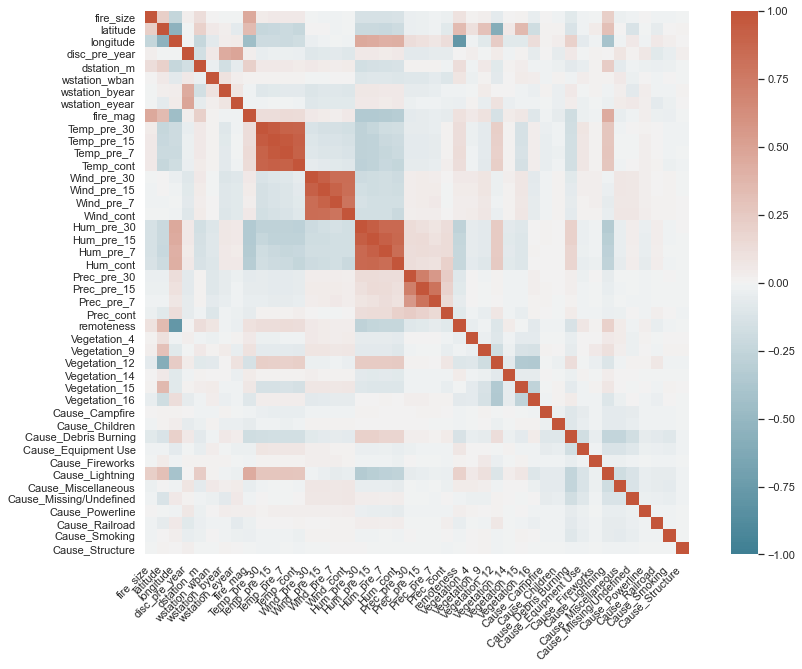

In [55]:
df_numerics_only = df.select_dtypes(include=np.number)

corr = df_numerics_only.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(rc={'figure.figsize':(15,10)})

In [56]:
# selecting features and target variables
X = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure']]
y = df['fire_size'] + df['fire_mag']

X_norm = (X-X.min())/(X.max()-X.min())
y_norm = (y-y.min())/(y.max()-y.min())

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
X = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']]
trans = MinMaxScaler()
X_trans = trans.fit_transform(X)
X_trans = pd.DataFrame(X_trans)
X = X_trans

df['fire_intensity'] = df['fire_size'] + df['fire_mag']
Y = df['fire_intensity']

In [42]:
Y

0           11.0
1            3.1
2           61.0
3            1.1
6            5.3
          ...   
55360     3550.0
55361    11799.0
55362     6389.0
55364     5802.0
55366    76167.0
Name: fire_intensity, Length: 38689, dtype: float64

In [ ]:
Y.array.reshape(-1, 1)
Y_trans= trans.fit_transform(Y)
Y_trans=pd.DataFrame(Y_trans)
Y_trans = Y_trans.rename(columns={0: "Intensity"})
y = Y_trans

## Modelling

### Deccision trees

In [57]:
# Deccision trees
dectr = DecisionTreeRegressor(random_state=0)
dectr.fit(X_train, y_train)
#cross_val_score(dectr, X_train, y_train, cv=10).mean()

DecisionTreeRegressor(random_state=0)

In [58]:
dectr.score(X_test,y_test)

-0.5247105207462748

In [59]:
predictions = dectr.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('R Squared:', metrics.r2_score(y_test, predictions))

Mean Absolute Error: 3399.394717856035
R Squared: -0.5247105207462748


### Gradient Boosting

In [60]:
gr_boost = GradientBoostingRegressor()
gr_boost.fit(X_train, y_train)

GradientBoostingRegressor()

In [61]:
#cross_val_score(gr_boost, X_train, y_train, cv=10).mean()

In [62]:
predictions = gr_boost.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('R Squared:', metrics.r2_score(y_test, predictions))

Mean Absolute Error: 3087.00544210433
R Squared: 0.08641296408053811


### Random Forest

In [ ]:
# Random Forest Regressor 
rf_reg = RandomForestRegressor(n_estimators = 500, max_depth=8)

# fit the regressor with x and y data
rf_reg.fit(X_train, y_train)  

In [66]:
predictions = rf_reg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('R Squared:', metrics.r2_score(y_test, predictions))

Mean Absolute Error: 3020.29732624605
R Squared: 0.1116672185102685


### Hyper-parameter tuning
Performing Grid Search, which tests the model with different values for parameters like the number of estimators and maximum depth, and then selects the parametres that produce the best results.

The basemodel of Random Forest Regressor produced the best results, so that is the algorithm we will tune.

In [ ]:
# Shwo which parameters can be tuned
rf_reg.get_params().keys()

In [124]:
search_grid={'n_estimators':[10,50,100,250],'max_depth':[2,4,5,6,7,8]}
rfreg = RandomForestRegressor()
search=GridSearchCV(estimator=gbr,param_grid=search_grid,scoring='r2',n_jobs=1,cv=5)
search.fit(X_train, y_train)
print(search.best_score_)
print(search.best_params_)

0.15844188723246325
{'max_depth': 8, 'n_estimators': 250}


### Fetaure Importance
What features are the most influential in the model?

In [83]:
feature_importances = pd.DataFrame(rf_reg.feature_importances_,
    index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
latitude,0.186960
Hum_cont,0.109403
Temp_pre_15,0.072151
Temp_cont,0.070898
Wind_pre_30,0.067238
Hum_pre_30,0.057932
Wind_cont,0.054491
Wind_pre_7,0.052445
Hum_pre_7,0.052050
Temp_pre_30,0.048335


In [77]:
#PCA Analysis
X_scaled = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2','pc3','pc4','pc5'])

X_pcca = principalDf[['pc1','pc2','pc3','pc4','pc5']]

Neural network model

In [100]:
model = Sequential([
    Dense(24, activation="relu"),
    Dense(64, activation="relu"),
    Dense(1, activation='linear')
])

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


In [101]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.15)


Epoch 1/10
823/823 [==============================] - 1s 1ms/step - loss: 2.6822e-04 - accuracy: 0.0070 - val_loss: 2.9432e-04 - val_accuracy: 0.0084
Epoch 2/10
823/823 [==============================] - 1s 1ms/step - loss: 2.6822e-04 - accuracy: 0.0070 - val_loss: 2.9432e-04 - val_accuracy: 0.0084
Epoch 3/10
823/823 [==============================] - 1s 942us/step - loss: 2.6822e-04 - accuracy: 0.0070 - val_loss: 2.9432e-04 - val_accuracy: 0.0084
Epoch 4/10
823/823 [==============================] - 1s 894us/step - loss: 2.6822e-04 - accuracy: 0.0070 - val_loss: 2.9432e-04 - val_accuracy: 0.0084
Epoch 5/10
823/823 [==============================] - 1s 953us/step - loss: 2.6822e-04 - accuracy: 0.0070 - val_loss: 2.9432e-04 - val_accuracy: 0.0084
Epoch 6/10
823/823 [==============================] - 1s 949us/step - loss: 2.6822e-04 - accuracy: 0.0070 - val_loss: 2.9432e-04 - val_accuracy: 0.0084
Epoch 7/10
823/823 [==============================] - 1s 1ms/step - loss: 2.6822e-04 - accur

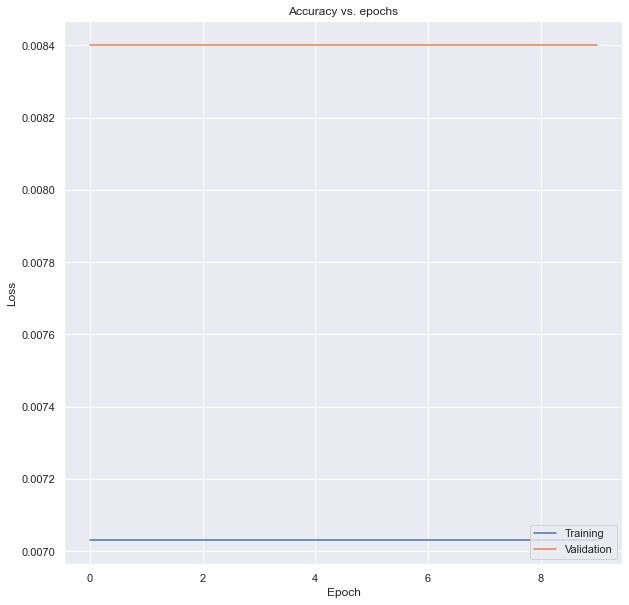

In [102]:
# Run this cell to plot the epoch vs accuracy graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

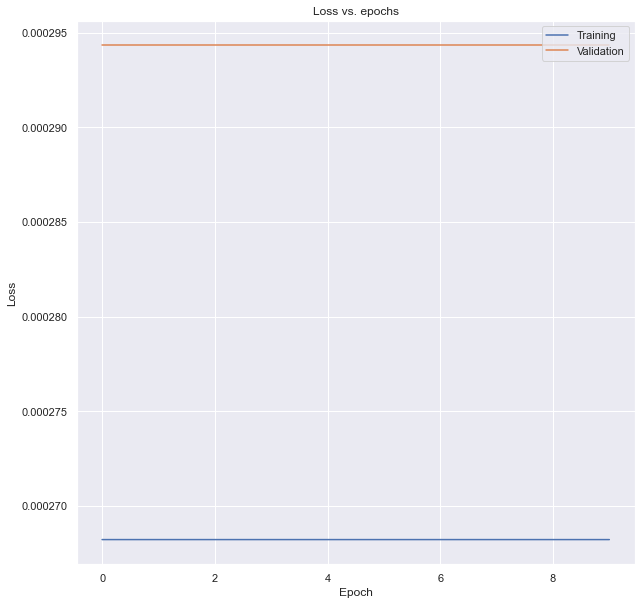

In [103]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

## Other

In [ ]:
# Get weather stations ordered by distance to Vancouver, BC
stations = Stations(lat = 38.843988, lon = -122.759707, daily = datetime(2018, 1, 1))
# Fetch closest station (limit = 1)
station = stations.fetch(1)

data = Daily(station, start = datetime(2018, 1, 1), end = datetime(2018, 1, 1))
# Fetch Pandas DataFrame
data = data.fetch()

data.plot(y=['tavg', 'tmin', 'tmax'])